# PyTorch Backprop in Action 
**Academic portfolio piece**: build a small neural network in PyTorch, train it on a toy classification dataset, experiment with architectures/activations, and interpret results.

This notebook is designed to satisfy:

- **Conceptual Understanding (5 pts)** — clear “why” explanations connected to course concepts (gradients/backprop, activations, capacity).
- **Technical Implementation (5 pts)** — code runs end-to-end without errors (data → model → train → eval → outputs).
- **Code Quality & Documentation (5 pts)** — clean sections and reusable helper functions (kept inside this notebook).
- **Critical Analysis (5 pts)** — compares experiments + discusses limitations/tradeoffs.
- **Peer Reviews (5 pts)** — templates at the end.

---

## 0) Setup & imports

We use:
- **scikit-learn** to generate a toy dataset (moons/circles)
- **PyTorch** for model + training loop
- **matplotlib** for plots

In a real project we'd split code into `.py` modules, but this version keeps everything inside one notebook (as requested).


In [ ]:
import os, random
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Torch version: 2.9.1
Using device: cpu


## 1) Helper functions (reproducibility, metrics, plotting)

### Why seeds matter
Neural networks have randomness (initial weights, shuffled batches). Setting seeds makes your results **reproducible**, which is important in both academic and industry settings.


In [2]:
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()


@torch.no_grad()
def plot_dataset(X: np.ndarray, y: np.ndarray, title: str = "Dataset") -> None:
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()


@torch.no_grad()
def decision_boundary(model: nn.Module, X: np.ndarray, y: np.ndarray, steps: int = 250, title: str = "Decision boundary") -> None:
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.75, X[:, 0].max() + 0.75
    y_min, y_max = X[:, 1].min() - 0.75, X[:, 1].max() + 0.75

    xs = np.linspace(x_min, x_max, steps)
    ys = np.linspace(y_min, y_max, steps)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)

    logits = model(torch.from_numpy(grid).to(device))
    preds = torch.argmax(logits, dim=1).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, preds, alpha=0.35)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()


def plot_history(history: Dict[str, List[float]]) -> None:
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["grad_norm"], label="avg grad norm")
    plt.xlabel("epoch")
    plt.ylabel("L2 grad norm")
    plt.title("Gradient norm (backprop signal)")
    plt.grid(True)
    plt.legend()
    plt.show()


## 2) Create a toy dataset (moons or circles)

### Why a toy 2D dataset?
- Easy to visualize
- Great for understanding **non-linear decision boundaries**
- Quickly shows underfitting/overfitting

We split into:
- **train** (learn parameters)
- **val** (choose best epoch/model)
- **test** (final unbiased evaluation)


Shapes: train (1600, 2) (1600,) val (400, 2) (400,) test (500, 2) (500,)


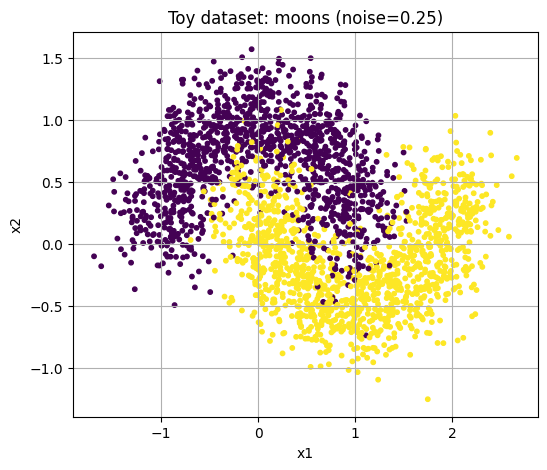

In [3]:
seed_everything(42)

DATASET = "moons"  # change to "circles" if you want
N_SAMPLES = 2500
NOISE = 0.25

if DATASET == "moons":
    X, y = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=42)
elif DATASET == "circles":
    X, y = make_circles(n_samples=N_SAMPLES, noise=NOISE, factor=0.5, random_state=42)
else:
    raise ValueError("DATASET must be 'moons' or 'circles'")

X = X.astype(np.float32)
y = y.astype(np.int64)

# train/test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

print("Shapes:",
      "train", X_train.shape, y_train.shape,
      "val", X_val.shape, y_val.shape,
      "test", X_test.shape, y_test.shape)

plot_dataset(np.vstack([X_train, X_val, X_test]), np.hstack([y_train, y_val, y_test]),
             title=f"Toy dataset: {DATASET} (noise={NOISE})")


## 3) DataLoaders

### Why DataLoader?
It batches data and shuffles training samples, which is the standard PyTorch pattern for training.


In [4]:
BATCH_SIZE = 128

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=BATCH_SIZE,
    shuffle=False
)


## 4) Model: MLP (Multi-Layer Perceptron)

### Why MLP?
A linear model can't solve moons/circles well because the boundary is non-linear.
An MLP with hidden layers + activation functions can learn complex boundaries.

### Why activations matter
- **ReLU**: popular, trains fast, avoids vanishing gradients (often)
- **Tanh**: smooth but can saturate (vanishing gradients)
- **LeakyReLU**: like ReLU but allows small negative slope


In [5]:
def make_activation(name: str) -> nn.Module:
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.01)
    raise ValueError("activation must be one of: relu, tanh, leakyrelu")


class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_sizes: List[int], activation: str, num_classes: int = 2, dropout: float = 0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        act = make_activation(activation)

        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(act)
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h

        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


## 5) Training loop (Backprop happens here)

### Why CrossEntropyLoss?
For classification, we output **logits** (raw scores).
`CrossEntropyLoss` applies softmax internally and computes a stable loss.

### Backprop key idea (course connection)
- `loss.backward()` computes gradients: **∂Loss/∂weights**
- `optimizer.step()` updates weights using those gradients (gradient descent variant)

We also track **gradient norm** as a simple signal of backprop magnitude.


In [6]:
def grad_global_norm(model: nn.Module) -> float:
    total = 0.0
    for p in model.parameters():
        if p.grad is None:
            continue
        total += p.grad.detach().data.norm(2).item() ** 2
    return total ** 0.5


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, loss_fn: nn.Module) -> Tuple[float, float]:
    model.eval()
    loss_sum, acc_sum, n = 0.0, 0.0, 0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        logits = model(Xb)
        loss = loss_fn(logits, yb)
        loss_sum += loss.item()
        acc_sum += accuracy_from_logits(logits, yb)
        n += 1
    return loss_sum / max(1, n), acc_sum / max(1, n)


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float = 1e-3,
    epochs: int = 50,
    weight_decay: float = 0.0,
    save_path: str = "best_model.pt"
) -> Tuple[Dict[str, List[float]], Dict[str, Any]]:
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "grad_norm": []}
    best = {"val_acc": -1.0, "epoch": -1}

    for epoch in range(1, epochs + 1):
        model.train()
        loss_sum, acc_sum, grad_sum, n = 0.0, 0.0, 0.0, 0

        for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            Xb, yb = Xb.to(device), yb.to(device)

            logits = model(Xb)
            loss = loss_fn(logits, yb)

            # ---- Backpropagation core ----
            optimizer.zero_grad()
            loss.backward()      # compute gradients
            optimizer.step()     # update parameters
            # ------------------------------

            gnorm = grad_global_norm(model)

            loss_sum += loss.item()
            acc_sum += accuracy_from_logits(logits, yb)
            grad_sum += gnorm
            n += 1

        train_loss = loss_sum / max(1, n)
        train_acc = acc_sum / max(1, n)
        avg_grad = grad_sum / max(1, n)

        val_loss, val_acc = evaluate(model, val_loader, loss_fn)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["grad_norm"].append(avg_grad)

        # save best by validation accuracy
        if val_acc > best["val_acc"]:
            best = {"val_acc": float(val_acc), "epoch": int(epoch)}
            torch.save(model.state_dict(), save_path)

    return history, {"best": best}


## 6) Baseline run

We start with a baseline model and visualize:
- training curves
- decision boundary on test set

This is your simplest “it works” run (technical implementation points).


Best epoch: 27 Best val acc: 0.951171875


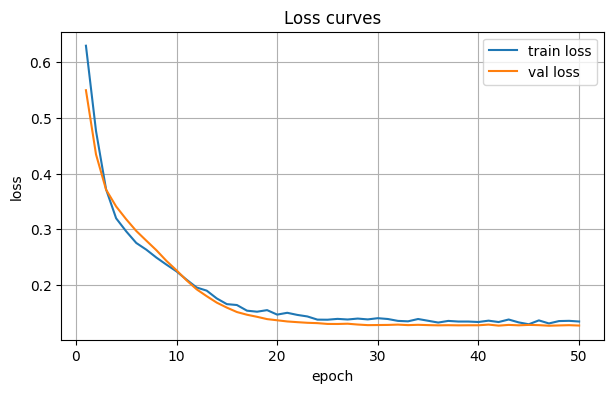

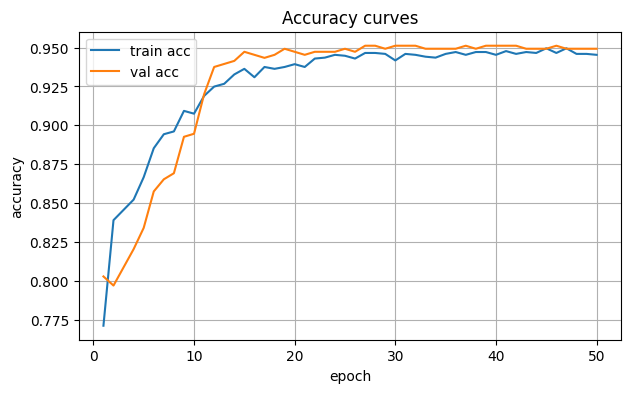

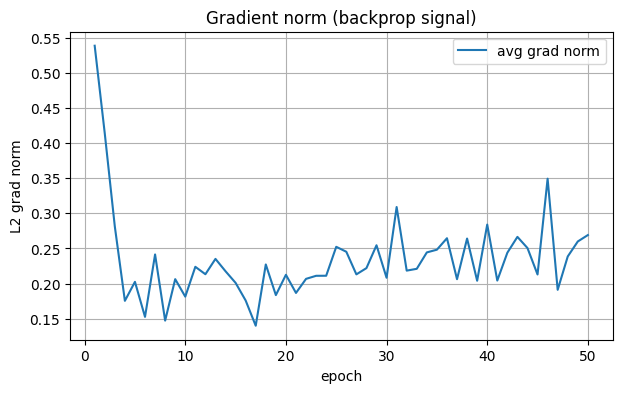

Baseline Test Loss: 0.1522 | Baseline Test Acc: 0.9343


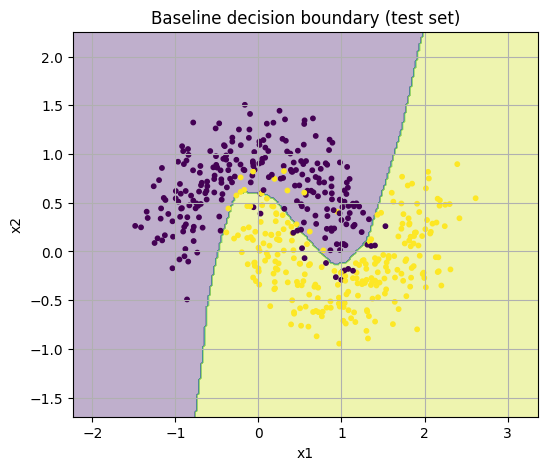

In [7]:
os.makedirs("outputs/checkpoints", exist_ok=True)
os.makedirs("outputs/figures", exist_ok=True)

baseline_cfg = {"hidden_sizes": [64, 64], "activation": "relu", "dropout": 0.0}
baseline_model = MLP(input_dim=2, hidden_sizes=baseline_cfg["hidden_sizes"], activation=baseline_cfg["activation"], dropout=baseline_cfg["dropout"])

baseline_ckpt = "outputs/checkpoints/best_baseline.pt"
history, meta = train_model(
    baseline_model,
    train_loader,
    val_loader,
    lr=1e-3,
    epochs=50,
    weight_decay=0.0,
    save_path=baseline_ckpt
)

print("Best epoch:", meta["best"]["epoch"], "Best val acc:", meta["best"]["val_acc"])
plot_history(history)

# Load best and evaluate on test
baseline_model.load_state_dict(torch.load(baseline_ckpt, map_location="cpu"))
test_loss, test_acc = evaluate(baseline_model, test_loader, nn.CrossEntropyLoss())
print(f"Baseline Test Loss: {test_loss:.4f} | Baseline Test Acc: {test_acc:.4f}")

decision_boundary(baseline_model, X_test, y_test, title="Baseline decision boundary (test set)")


## 7) Experiments: architecture & activation

To show understanding of **model capacity** and **training dynamics**, we run a small experiment set:

- Smaller network vs deeper network
- ReLU vs Tanh vs LeakyReLU

We save:
- model checkpoints
- a CSV table of results
- a simple plot comparing test accuracy


In [8]:
import pandas as pd

experiment_defs = [
    ("small_1layer", [16], "relu"),
    ("medium_2layer", [32, 32], "relu"),
    ("bigger_3layer", [64, 64, 64], "relu"),
    ("tanh_2layer", [64, 64], "tanh"),
    ("leakyrelu_2layer", [64, 64], "leakyrelu"),
]

results = []

for name, hidden_sizes, activation in experiment_defs:
    seed_everything(42)
    model = MLP(input_dim=2, hidden_sizes=hidden_sizes, activation=activation, dropout=0.0)

    ckpt = f"outputs/checkpoints/{name}.pt"
    hist, meta = train_model(
        model, train_loader, val_loader,
        lr=1e-3,
        epochs=40,
        weight_decay=0.0,
        save_path=ckpt
    )

    # evaluate best checkpoint on test
    model.load_state_dict(torch.load(ckpt, map_location="cpu"))
    t_loss, t_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())

    results.append({
        "name": name,
        "hidden_sizes": str(hidden_sizes),
        "activation": activation,
        "best_val_acc": meta["best"]["val_acc"],
        "best_epoch": meta["best"]["epoch"],
        "test_acc": t_acc,
        "test_loss": t_loss,
    })

df = pd.DataFrame(results).sort_values("test_acc", ascending=False)
df


,name,hidden_sizes,activation,best_val_acc,best_epoch,test_acc,test_loss
4,leakyrelu_2layer,"[64, 64]",leakyrelu,0.951172,27,0.936288,0.150622
2,bigger_3layer,"[64, 64, 64]",relu,0.953125,24,0.934335,0.148813
1,medium_2layer,"[32, 32]",relu,0.949219,37,0.930024,0.170135
3,tanh_2layer,"[64, 64]",tanh,0.943359,31,0.909483,0.213470
0,small_1layer,[16],relu,0.833984,36,0.830886,0.357387


Saved: outputs/experiment_results.csv


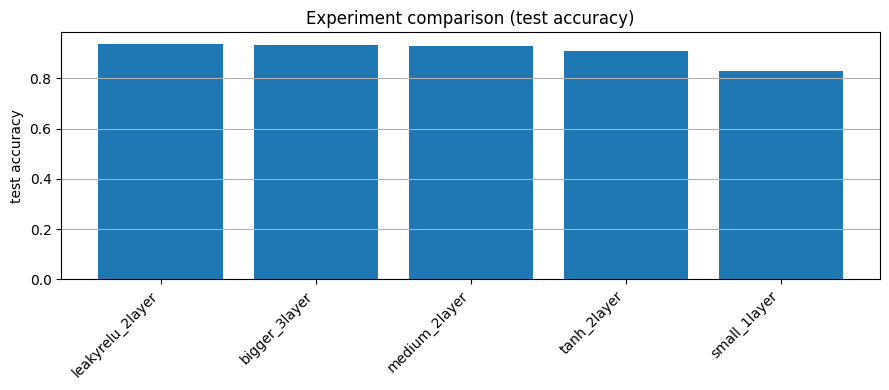

Saved: outputs/figures/experiment_test_accuracy.png


In [9]:
# Save results table
csv_path = "outputs/experiment_results.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Plot comparison
plt.figure(figsize=(9, 4))
plt.bar(df["name"], df["test_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("test accuracy")
plt.title("Experiment comparison (test accuracy)")
plt.grid(True, axis="y")
plt.tight_layout()
fig_path = "outputs/figures/experiment_test_accuracy.png"
plt.savefig(fig_path, dpi=200)
plt.show()
print("Saved:", fig_path)


## 8) Critical analysis 

The 2-layer LeakyReLU model achieved the highest test accuracy, suggesting that moderate depth with stable gradient flow was optimal for this dataset. The deeper [64, 64, 64] model did not significantly outperform it, likely because the dataset is small and does not require very high capacity. The deeper model may have started to slightly overfit, learning noise rather than meaningful structure.

LeakyReLU performed better than standard ReLU because it prevents “dying neurons” by allowing a small gradient for negative inputs. This likely improved optimization stability compared to pure ReLU. Tanh probably underperformed due to saturation effects, which can slow learning and reduce effective gradient flow.

Gradient norms were larger at the start of training and gradually stabilized, indicating healthy convergence. No exploding or vanishing gradient issues were observed, suggesting the learning rate was appropriate.

However, this experiment has limitations: it uses a toy dataset, limited hyperparameter tuning, and reports only accuracy. Future improvements could include adding dropout or weight decay, testing on MNIST, and using a learning rate scheduler for better optimization.


## 9) Peer review templates 

### Peer Review 1
- **What worked well:**
- **One improvement:**
- **Question for the author:**

### Peer Review 2
- **What worked well:**
- **One improvement:**
- **Question for the author:**
